## Going Deeper - The Mechanics of Pytorch

The topics that we will cover are as follows:

* Understanding and working with PyTorch computation graphs
* Working with PyTorch tensor objects
* Solving the classic XOR problem and understanding model capacity
* Building complex NN models using PyTorch’s Sequential class and the nn.Module class
* Computing gradients using automatic differentiation and torch.autograd

In [2]:
!pip install -q -r requirements.txt

### Creating a graph in PyTorch

In [3]:
import torch
def compute_z(a,b,c):
    r1 = torch.sub(a,b)
    r2 = torch.mul(r1,2)
    z = torch.add(r2,c)
    return z

print('Scalar inputs: ', compute_z(torch.tensor(1),torch.tensor(2),torch.tensor(3)))
print('Rank 1 inputs: ', compute_z(torch.tensor([1]),torch.tensor([2]),torch.tensor([3])))
print('Rank 2 inputs: ', compute_z(torch.tensor([[1]]),torch.tensor([[2]]),torch.tensor([[3]])))


Scalar inputs:  tensor(1)
Rank 1 inputs:  tensor([1])
Rank 2 inputs:  tensor([[1]])


### PyTorch tensor objects for storing and updating model parameters

In [4]:
a = torch.tensor(3.14,requires_grad=True)
print(a)
b = torch.tensor([1.0,2.0,3.0],requires_grad=True)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


Notice that requires_grad is set to False by default. This value can be efficiently set to True by run-
ning requires_grad_().

In [5]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)
w.requires_grad_()
print(w.requires_grad)

False
True


> You will recall that for NN models, initializing model parameters with random weights is necessary to
> break the symmetry during backpropagation—otherwise, a multilayer NN would be no more useful
> than a single-layer NN like logistic regression. When creating a PyTorch tensor, we can also use a
> random initialization scheme. PyTorch can generate random numbers based on a variety of proba-
> bility distributions

> So, let’s look at how we can create a tensor with Glorot initialization, which is a classic random ini-
> tialization scheme that was proposed by Xavier Glorot and Yoshua Bengio. For this, we first create
> an empty tensor and an operator called init as an object of class GlorotNormal. Then, we fill this
> tensor with values according to the Glorot initialization by calling the xavier_normal_() method. In
> the following example, we initialize a tensor of shape 2×3:


In [6]:
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2,3)
nn.init.xavier_normal_(w)
print('First iteration of random tensor \n', w)
nn.init.xavier_normal_(w)
print('Second iteration of random tensor \n',w)

First iteration of random tensor 
 tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])
Second iteration of random tensor 
 tensor([[-0.9631,  0.2414, -0.6499],
        [-0.3561, -0.5643, -0.0368]])


**Now, to put this into the context of a more practical use case, let’s see how we can define two Tensor objects inside the base nn.Module class:**

In [7]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

These two tensors can be then used as weights whose gradients will be computed via automatic dif-
ferentiation.

> #### **Computing gradients via automatic differentiation**


>> As you already know, optimizing NNs requires computing the gradients of the loss with respect to the
NN weights. This is required for optimization algorithms such as stochastic gradient descent (SGD).
In addition, gradients have other applications, such as diagnosing the network to find out why an NN
model is making a particular prediction for a test example. Therefore, in this section, we will cover
how to compute gradients of a computation with respect to its input variables.

> #### **Computing the gradients of the loss with respect to trainable variables** 

Let’s work with a simple example where we will compute z = wx + b and define the loss as the squared
loss between the target y and prediction z, Loss = (y – z)2. In the more general case, where we may have
multiple predictions and targets, we compute the loss as the sum of the squared error,𝐿 ∑𝑖𝑖(𝑦𝑦𝑖𝑖 − 𝑧𝑧𝑖𝑖 )2
. In order to implement this computation in PyTorch, we will define the model parameters, w and b,
as variables (tensors with the requires_gradient attribute set to True), and the input, x and y, as
default tensors. We will compute the loss tensor and use it to compute the gradients of the model
parameters, w and b, as follows:

In [8]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


Computing the value z is a forward pass in an NN. We used the backward method on the loss tensor
      to compute
      𝜕loss 
      𝜕w &  𝜕loss
            𝜕b.
      Since this is a very simple example, we can obtain
      𝜕loss
      𝜕w     = 2𝑥(𝑤x + 𝑏 - y)
      symbolically to verify that the computed gradients match the results we obtained in the previous
      code example:

In [9]:
 # verifying the computed gradient
print(2 * x * ((w * x + b) - y))
# tensor([-0.5600], grad_fn=<MulBackward0>)

tensor([-0.5600], grad_fn=<MulBackward0>)


> ### Simplifying implementations of common architectures via the torch.nn module

>> #### Implementing models based on nn.Sequential

In [10]:
model = nn.Sequential(
    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

We specified the layers and instantiated the model after passing the layers to the nn.Sequential class.
The output of the first fully connected layer is used as the input to the first ReLU layer. The output of
the first ReLU layer becomes the input for the second fully connected layer. Finally, the output of the
second fully connected layer is used as the input to the second ReLU layer.
We can further configure these layers, for example, by applying different activation functions, initial-
izers, or regularization methods to the parameters. A comprehensive and complete list of available
options for most of these categories can be found in the official documentation:

* Choosing activation functions: https://pytorch.org/docs/stable/nn.html#non-linear-
activations-weighted-sum-nonlinearity
* Initializing the layer parameters via nn.init: https://pytorch.org/docs/stable/nn.init.
html
* Applying L2 regularization to the layer parameters (to prevent overfitting) via the parameter
weight_decay of some optimizers in torch.optim: https://pytorch.org/docs/stable/optim.
html
* Applying L1 regularization to the layer parameters (to prevent overfitting) by adding the L1
penalty term to the loss tensor, which we will implement next

In [11]:
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

Here, we initialized the weight of the first linear layer with Xavier initialization. And we computed
the L1 norm of the weight of the second linear layer.
Furthermore, we can also specify the type of optimizer and the loss function for training. Again, a
comprehensive list of all available options can be found in the official documentation:

* Optimizers via torch.optim: https://pytorch.org/docs/stable/optim.html#algorithms
* Loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

> Choosing a loss function

>> Regarding the choices for optimization algorithms, SGD and Adam are the most widely used methods.
The choice of loss function depends on the task; for example, you might use mean square error loss
for a regression problem.

>> The family of cross-entropy loss functions supplies the possible choices for classification tasks, which
are extensively discussed in Chapter 14, Classifying Images with Deep Convolutional Neural Networks.

>> Furthermore, you can use the techniques you have learned from previous chapters (such as techniques
for model evaluation from Chapter 6, Learning Best Practices for Model Evaluation and Hyperparameter
Tuning) combined with the appropriate metrics for the problem. For example, precision and recall,
accuracy, area under the curve (AUC), and false negative and false positive scores are appropriate
metrics for evaluating classification models.

In this example, we will use the SGD optimizer, and cross-entropy loss for binary classification:

In [12]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

> ### Solving an XOR classification problem

The XOR classification problem is a classic problem for analyzing the capacity of a model with regard
to capturing the nonlinear decision boundary between two classes. We generate a toy dataset of 200
training examples with two features (x0, x1) drawn from a uniform distribution between [–1, 1). Then,
we assign the ground truth label for training example i according to the following rule:

We will use half of the data (100 training examples) for training and the remaining half for validation.
The code for generating the data and splitting it into the training and validation datasets is as follows:

Text(0, 0.5, '$x_2$')

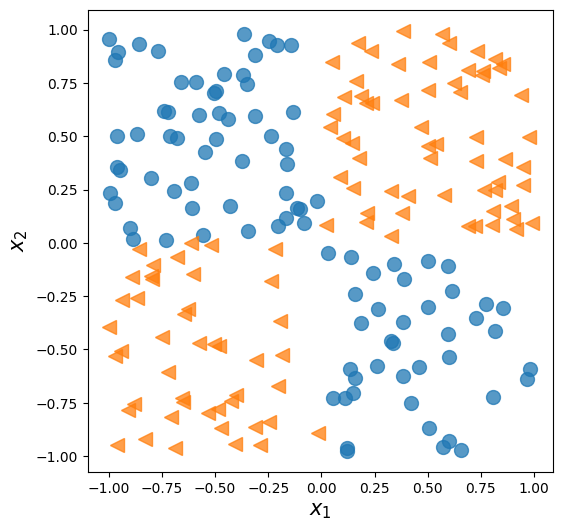

In [13]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1,high=1,size=(200,2))
y = np.ones(len(x))
y[x[:,0]*x[:,1]<0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)


The code results in the following scatterplot of the training and validation examples, shown with
different markers based on their class label:

In the previous subsection, we covered the essential tools that we need to implement a classifier in
PyTorch. We now need to decide what architecture we should choose for this task and dataset. As
a general rule of thumb, the more layers we have, and the more neurons we have in each layer, the
larger the capacity of the model will be. Here, the model capacity can be thought of as a measure of
how readily the model can approximate complex functions. While having more parameters means
the network can fit more complex functions, larger models are usually harder to train (and prone to
overfitting). In practice, it is always a good idea to start with a simple model as a baseline, for example,
a single-layer NN like logistic regression:

In [14]:
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)
model


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

After defining the model, we will initialize the cross-entropy loss function for binary classification and the SGD optimizer:

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Next, we will create a data loader that uses a batch size of 2 for the train data:

In [16]:
from torch.utils.data import DataLoader,TensorDataset
train_ds = TensorDataset(x_train,y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds,batch_size,shuffle=True)

Now we will train the model for 200 epochs and record a history of training epochs:

In [17]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= n_train
        accuracy_hist_train[epoch] /= n_train/batch_size
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Notice that the history of training epochs includes the train loss and validation loss and the train accu-
racy and validation accuracy, which is useful for visual inspection after training. In the following code,
we will plot the learning curves, including the training and validation loss, as well as their accuracies.
The following code will plot the training performance:

Text(0.5, 0, 'Epochs')

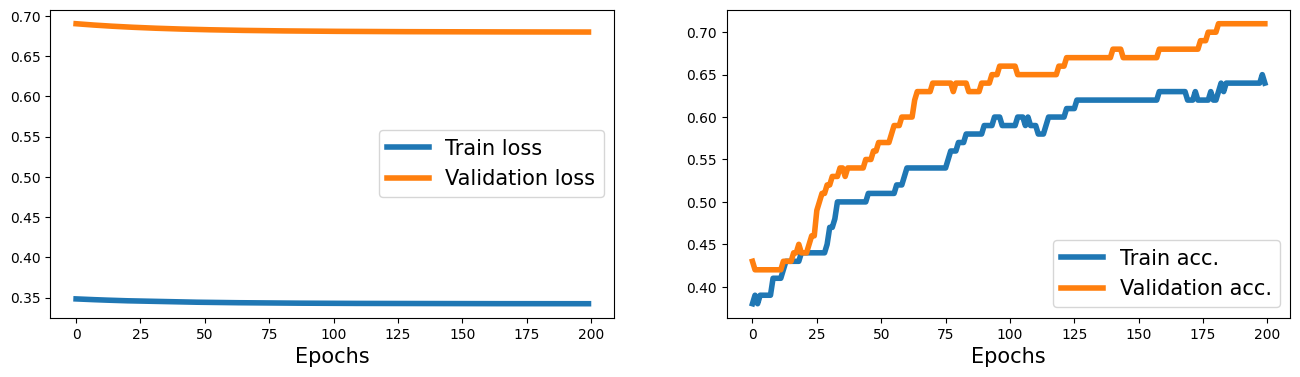

In [18]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

As you can see, a simple model with no hidden layer can only derive a linear decision boundary, which
is unable to solve the XOR problem. As a consequence, we can observe that the loss terms for both the
training and the validation datasets are very high, and the classification accuracy is very low.

To derive a nonlinear decision boundary, we can add one or more hidden layers connected via nonlinear
activation functions. The universal approximation theorem states that a feedforward NN with a single
hidden layer and a relatively large number of hidden units can approximate arbitrary continuous func-
tions relatively well. Thus, one approach for tackling the XOR problem more satisfactorily is to add a
hidden layer and compare different numbers of hidden units until we observe satisfactory results on
the validation dataset. Adding more hidden units would correspond to increasing the width of a layer.

Alternatively, we can also add more hidden layers, which will make the model deeper. The advantage
of making a network deeper rather than wider is that fewer parameters are required to achieve a
comparable model capacity.

However, a downside of deep (versus wide) models is that deep models are prone to vanishing and
exploding gradients, which make them harder to train.

As an exercise, try adding one, two, three, and four hidden layers, each with four hidden units. In
the following example, we will take a look at the results of a feedforward NN with two hidden layers:

In [19]:
model = nn.Sequential(
nn.Linear(2, 4),
nn.ReLU(),
nn.Linear(4, 4),
nn.ReLU(),
nn.Linear(4, 1),
nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
model
# Sequential(

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [20]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

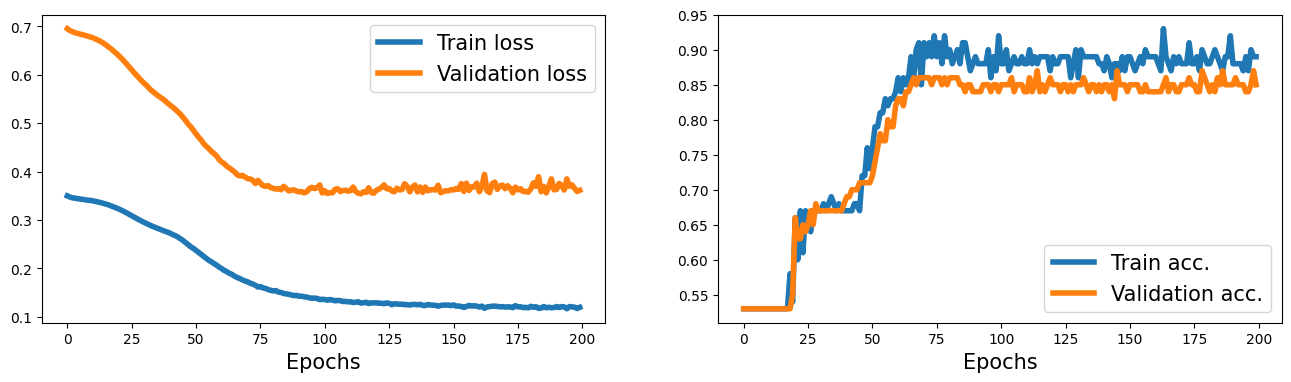

In [21]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

Now, we can see that the model is able to derive a nonlinear decision boundary for this data, and the
model reaches 100 percent accuracy on the training dataset. The validation dataset’s accuracy is 95
percent, which indicates that the model is slightly overfitting.

> ### **Making model building more flexible with nn.Module**

In the previous example, we used the PyTorch Sequential class to create a fully connected NN with
multiple layers. This is a very common and convenient way of building models. However, it unfortu-
nately doesn’t allow us to create more complex models that have multiple input, output, or intermediate
branches. That’s where nn.Module comes in handy.

The alternative way to build complex models is by subclassing nn.Module. In this approach, we create a
new class derived from nn.Module and define the method, __init__(), as a constructor. The forward()
method is used to specify the forward pass. In the constructor function, __init__(), we define the
layers as attributes of the class so that they can be accessed via the self reference attribute. Then, in
the forward() method, we specify how these layers are to be used in the forward pass of the NN. The
code for defining a new class that implements the previous model is as follows:

In [23]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)


    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    

Notice that we put all layers in the nn.ModuleList object, which is just a list object composed of
nn.Module items. This makes the code more readable and easier to follow.
Once we define an instance of this new class, we can train it as we did previously:

In [30]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Once we define an instance of this new class, we can train it as we did previously:

In [26]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Next, besides the train history, we will use the mlxtend library to visualize the validation data and
the decision boundary.

In [27]:
pip install mlxtend

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/73/da/d5d77a9a7a135c948dbf8d3b873655b105a152d69e590150c83d23c3d070/mlxtend-0.23.0-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.2.1 from https://files.pythonhosted.org/packages/ef/1b/7538792254aec6850657d5b940fd05fe60582af829ffe40d6c054f065f34/scipy-1.11.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scipy-1.11.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Obtaining dependency information for scikit-learn>=1.0.2 from https://files.pythonhosted.org/packages/8f/87/5969092159207f583481ad80a03f09e2d4af1ebd197f4530ca4e906c947e/scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for joblib>=0.13.2 from https://files.pythonhost

To compute the decision boundary of our model, we need to add a predict() method in the MyModule
class:

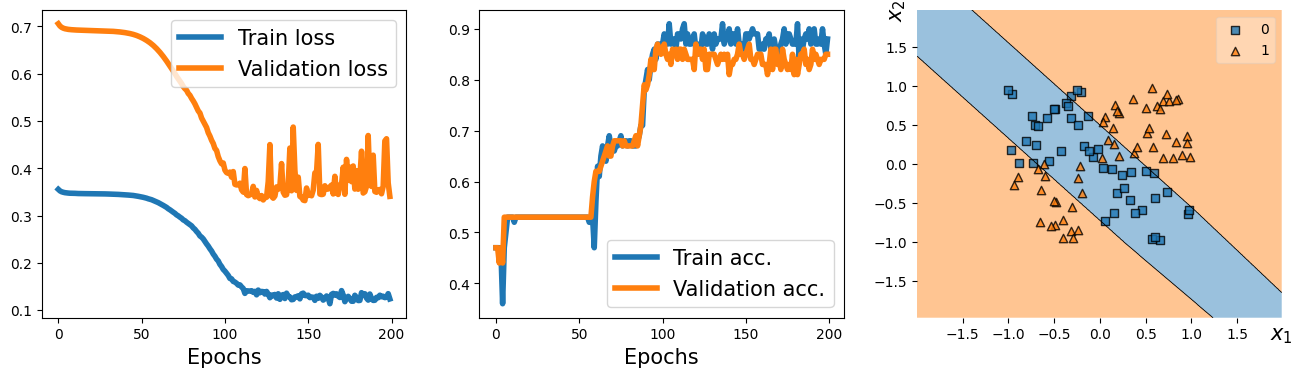

In [37]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

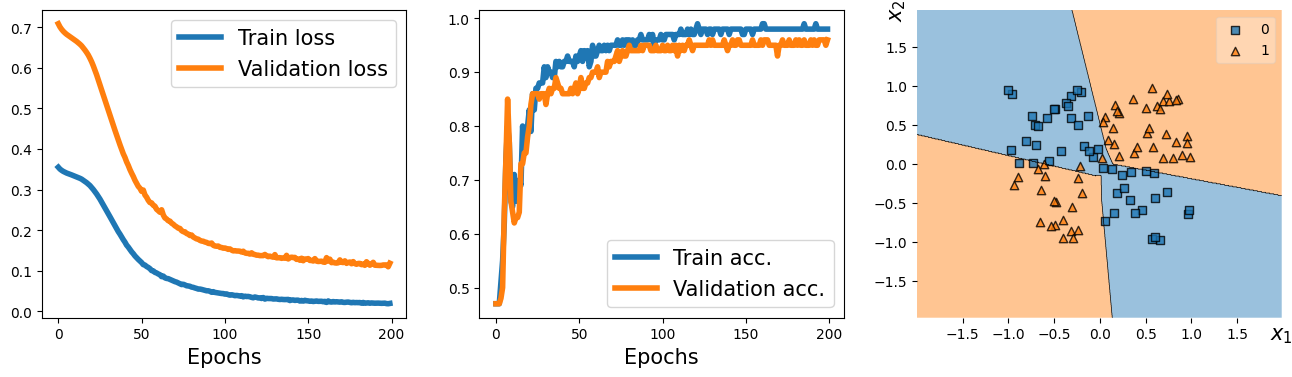

This results in Figure 13.5, with three separate panels for the losses, accuracies, and the scatterplot
of the validation examples, along with the decision boundary:

> Writing custom layers in PyTorch

In [38]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b) 

In [39]:
## testing:

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
 
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))
 
print(noisy_layer(x, training=False))


tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [40]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

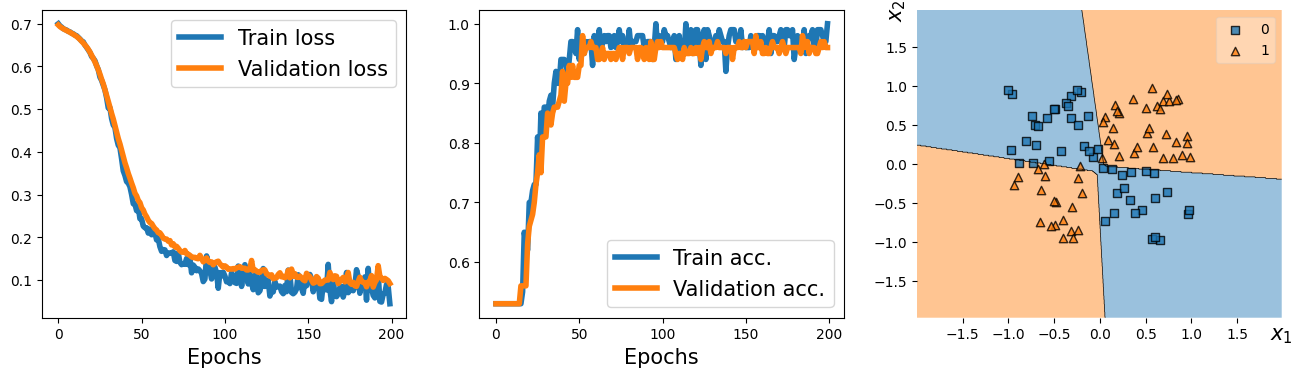

In [41]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_06.png', dpi=300)
plt.show()